# Domestic Incidents Involving Shipment of Hazardous Material 

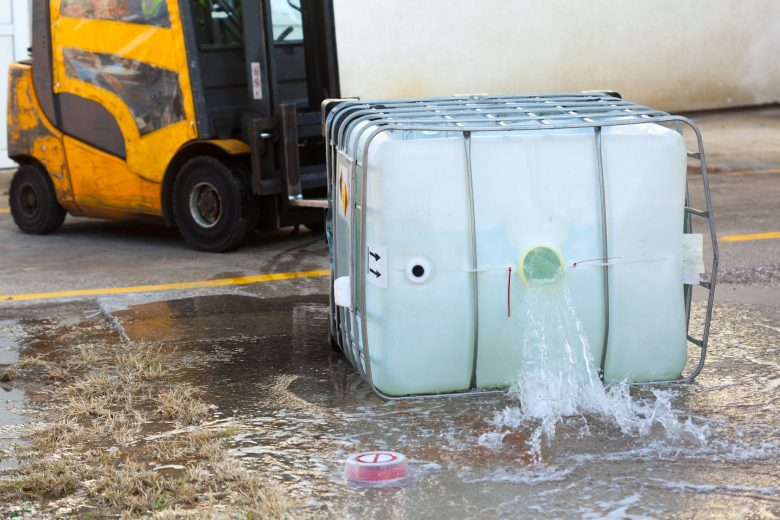

### Table of Contents

* [Introduction](#Introduction)
* [Import Libraries](#Lib)
* [Data Overview](#Data)
* [Graphical Plots](#Graph)
* [Initial Cleaning and Further Plots](#Clean)
* [WordCloud](#WordCloud)
* [Data Preperation for Correlations and Decision Tree Analysis](#Prep)
* [Correlations Associated with Serious Incidents](#Corr)
* [Decision Tree Analysis](#Dec)
* [Conclusion](#Conclusion)


<a id='Introduction'></a>
## Introduction





The scope of the project are hazardous materials being shipped domestically from May 2021 to May 2023.  The project will only analyze containers shipped in IBC size containers or smaller.  

The goal is to find any commonalities between incidents that became serious versus more mudane failures in the shipping of hazardous chemicals.  Serious incidents may include bulk releases that require hazmat teams to clear, fires, large vapor releases and even radiation.  The results of such incidents include property damage, road closures, evacuations or even injury and death.  By analyzing these serious incidints we can segregate minor incidents which could of become serious if just one more factor went wrong and incidents that had little to no risk of becomming severe.
 
The source for this dataset is [*Pipeline and Hazardous Materials Safety Administration*](https://www.phmsa.dot.gov/) is under the Department of Transportation and is responsible for the advancing the safe transportation of energy and other hazardous material to promote the wellbeing of people and the environment.  CSV file was created using this [search engine](https://portal.phmsa.dot.gov/analytics/saw.dll?Portalpages&PortalPath=%2Fshared%2FPublic%20Website%20Pages%2F_portal%2FHazmat%20Incident%20Report%20Search).  The image below are the search terms used in the generation of this CSV file. 



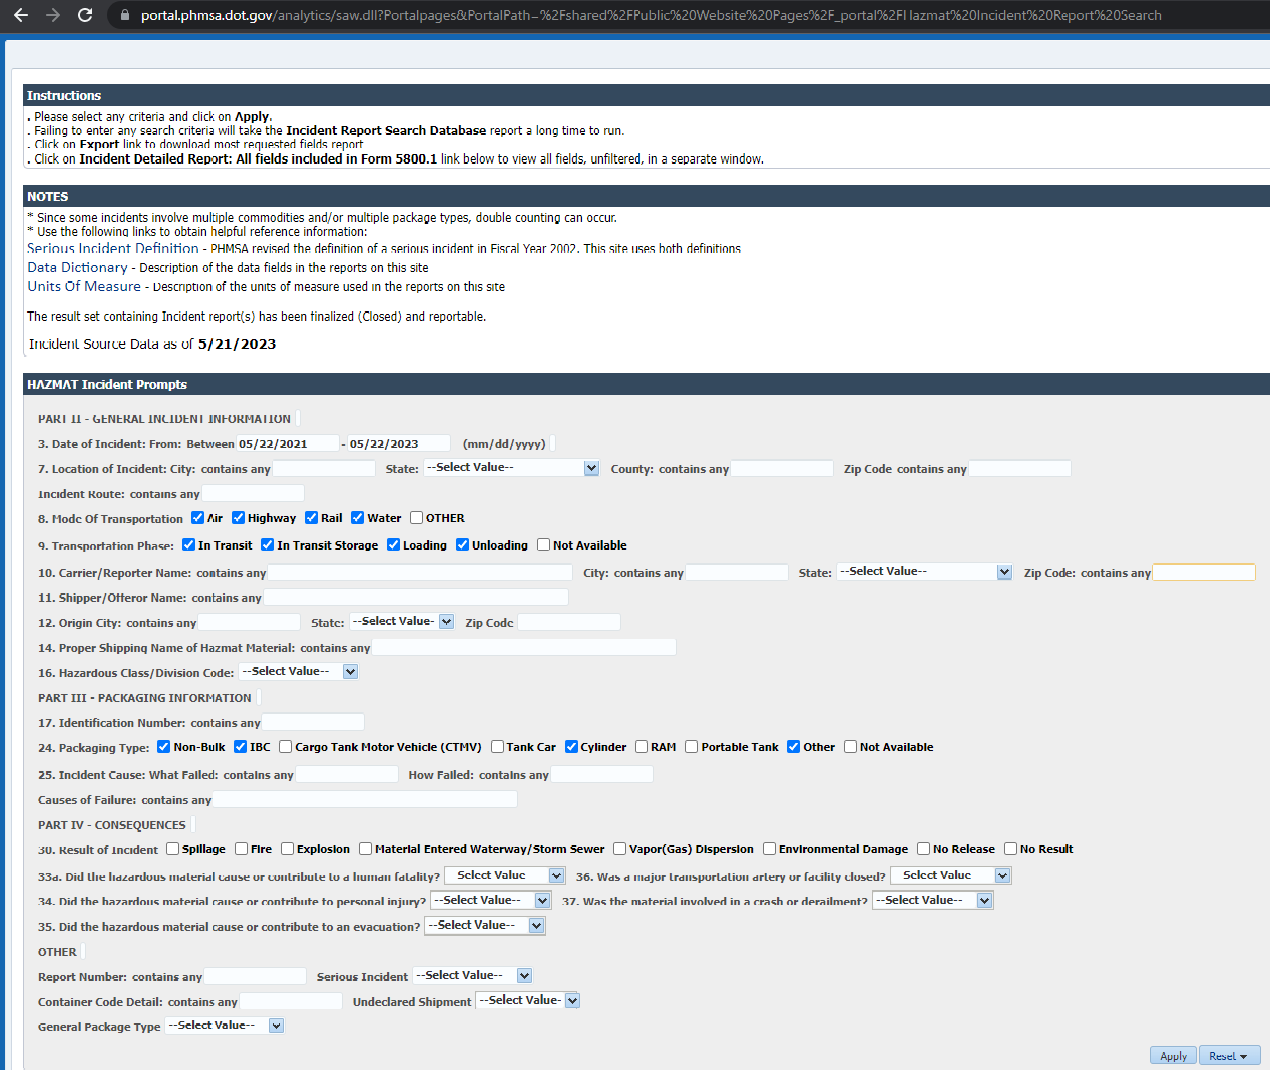





<a id='Lib'></a>
## Import Libraries and Functions

In [1]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn import tree
from PIL import Image
import graphviz
import pydotplus
import collections

sns.set_style(style='darkgrid')

In [2]:
# Function used to add labels containing values to top of bars in seaborn barplots
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.0f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

<a id='Data'></a>
## Data Overview

In [3]:
# read csv file into pandas dataframe
shipping=pd.read_csv('/content/drive/MyDrive/Incident ReportShippingMay2021-May2023.csv')
# print information on columns in dataframe
shipping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48800 entries, 0 to 48799
Data columns (total 43 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Report Number                    48800 non-null  object 
 1   Multiple Rows Per Incident       48800 non-null  object 
 2   Carrier Reporter Name            48800 non-null  object 
 3   Incident Route                   47703 non-null  object 
 4   Incident City                    48799 non-null  object 
 5   Incident State                   48527 non-null  object 
 6   Date Of Incident                 48800 non-null  object 
 7   Incident Time                    48800 non-null  int64  
 8   Quantity Released                48800 non-null  float64
 9   Unit Of Measure                  46558 non-null  object 
 10  Identification Number            48733 non-null  object 
 11  Commodity Long Name              48726 non-null  object 
 12  Hazardous Class   

There are 43 columns in the dataset.  Only 10 of the columns are in a numerical format while the rest of the data is in a string format.  Further there are a lot of null values.  


First we will need to determine what data is relevent or not and later on find a way to transform the strings into some sort of numerical values before the data can be processed using any statistical and machine learning models.  Next will need to deal with the null values.



Next step is to generate various initial plots to determine how best to proceed.  

<a id='Graph'></a>
## Graphical Plots

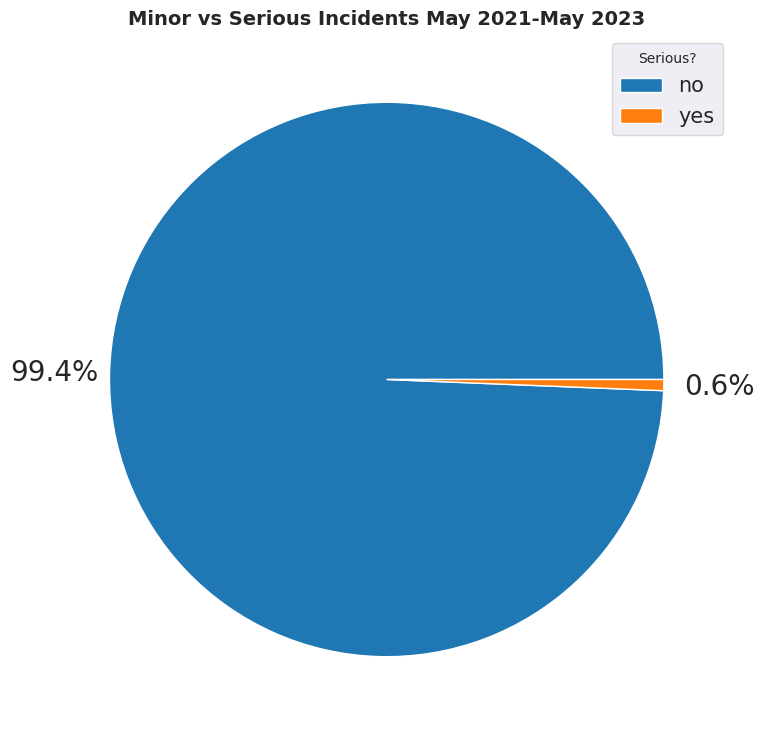

In [4]:
# size of plot
plt.figure(figsize=(9,9))
# create pie plot using data from 'Serious Indicator' column in dataframe
shipping['Serious Indicator'].value_counts(normalize=True).plot.pie(autopct='%1.1f%%', labeldistance=None, fontsize=20, pctdistance=1.2)
# title and legend setup and removal of ylabel for readability
plt.title('Minor vs Serious Incidents May 2021-May 2023', weight='bold', size=14)
plt.ylabel('')
plt.legend(labels=['no','yes'], title='Serious?', fontsize=15)

The outcome variable *Serious Indicator* is extremely unbalanced.  Only 0.6% of the data is indicated to be a *serious incident*.  This will likely make modeling difficult.  


Next we will look at the packaging of containers 1 and 2 with horizontal barplots using [seaborn](https://seaborn.pydata.org/generated/seaborn.barplot.html) library.  The estimator used by this library defaults to 'mean.'

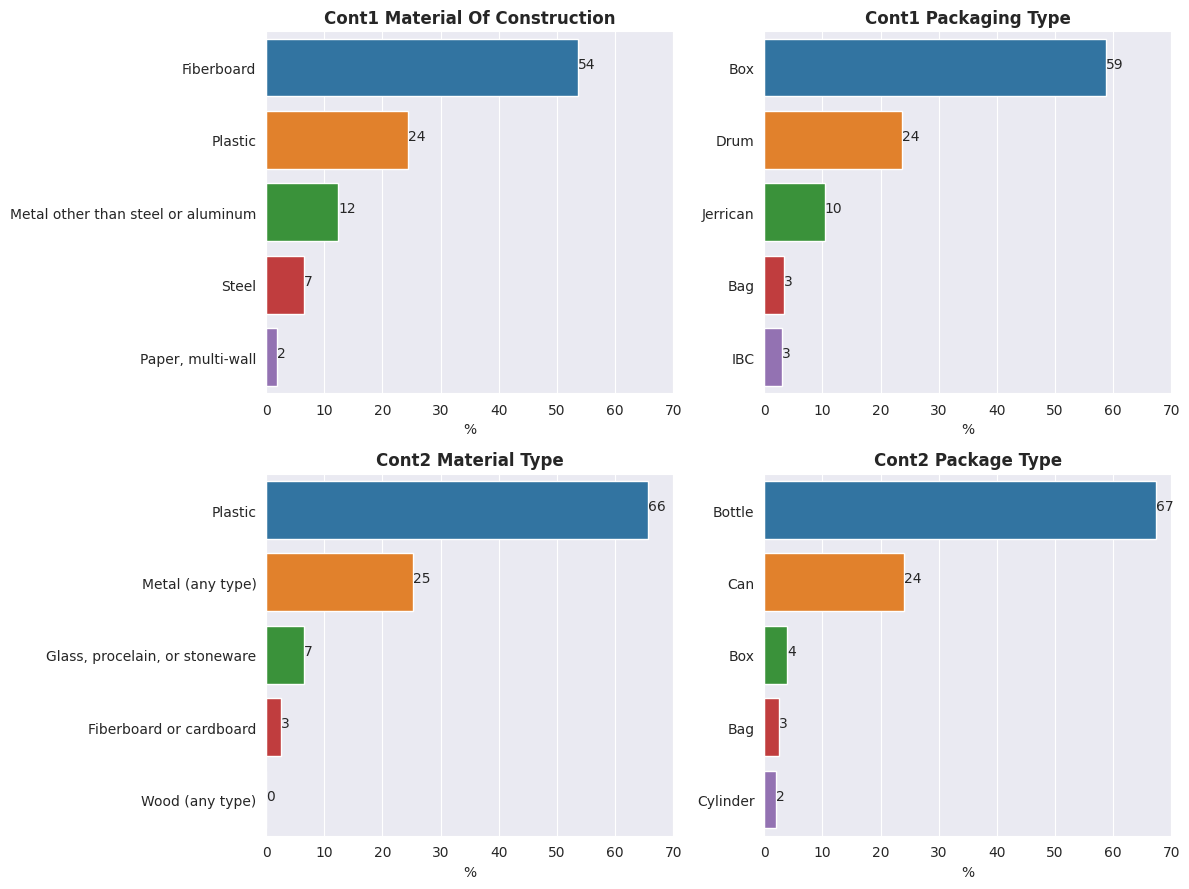

In [5]:
# list of columns related to packaging material
package=['Cont1 Material Of Construction', 'Cont1 Packaging Type', 'Cont2 Material Type', 'Cont2 Package Type']

# size of plot figure
plt.figure(figsize=(12,9))

# loop through package list with subplots using different columns
for i, pack in enumerate(package):
  plt.subplot(2,2, i+1)
  # data set up for individual column barplots rounded to 2 decimal places from highest values to lowest.  Top 5 values only
  data=round(shipping[pack].value_counts(normalize=True).sort_values(ascending=False).head(5)*100,2)
  # seaborn barplot using index of data as y-values and values of dataframe as x-values
  p=sns.barplot(y=data.index, x=data)
  plt.title(f'{pack}', weight='bold')
  plt.ylabel('')
  plt.xlabel('%')
  # make sure x limit is the same for all subplots for readability
  plt.xlim(0,70)
  # using show_values function to print values at the end of bars
  p=show_values(p, orient='h')
plt.tight_layout()
plt.show()  

Cont1 refers to outside packaging if double packaged. 
Cont2 refers to inner packaging if double packaged.



* Incidents involving Cont1 tend to be fiberboard boxes

* Incidents involving Cont2 tend to be plastic bottles




Next want transform 'Date of Incident' into a datetime format using pandas [datetime](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html) method.  Using the datetime formated data it will then be easy to further breakdown the dates into yearly quarters for further analysis using pandas [to_period](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_period.html) method.




Next create barplots of quantity released and total damages seperated by yearly quarters. 

In [6]:
# transform date of incident into datetime format using pandas.to_datetime method
shipping['Date Of Incident']=pd.to_datetime(shipping['Date Of Incident'])
# create new column 'quarter' from 'Date of Incident.'
shipping['quarter'] = shipping['Date Of Incident'].dt.to_period('Q')

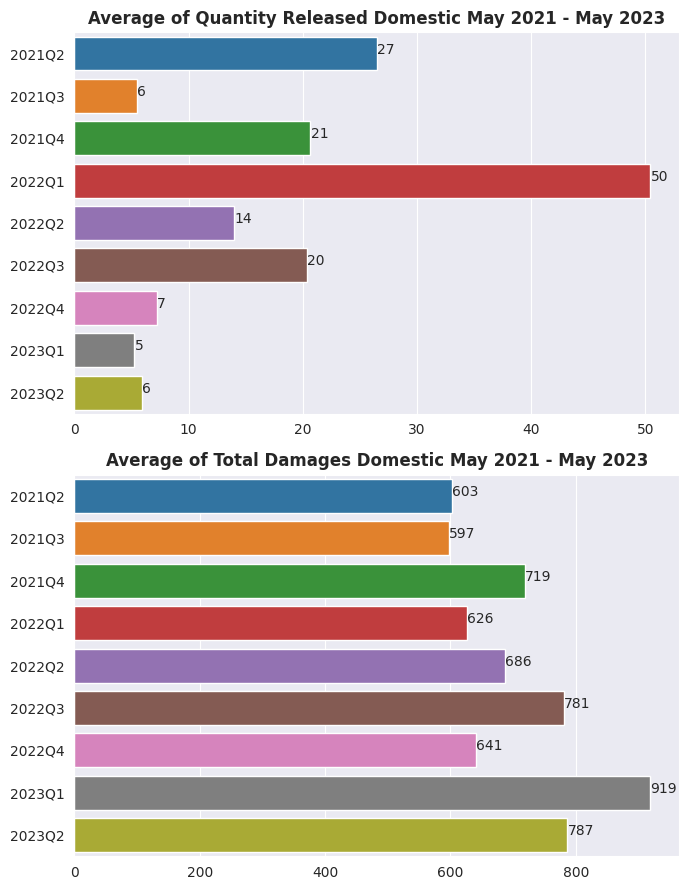

In [7]:
# lists of columns 
damages=['Quantity Released', 'Total Damages']
# size of plot figure
plt.figure(figsize=(7,9))
# loop through damages list
for i, dam in enumerate(damages):
  plt.subplot(2,1, i+1)
  p=sns.barplot(data=shipping, y='quarter', x=dam, errorbar=None)
  plt.title(f'Average of {dam} Domestic May 2021 - May 2023', weight='bold')
  plt.xlabel('')
  plt.ylabel('')
  show_values(p, orient='h')
plt.tight_layout()
plt.show()

* Q1 of 2022 had an average release of 50 gallons which seems excessivly high
* Average damages range from about \$600 to \$900 per incident

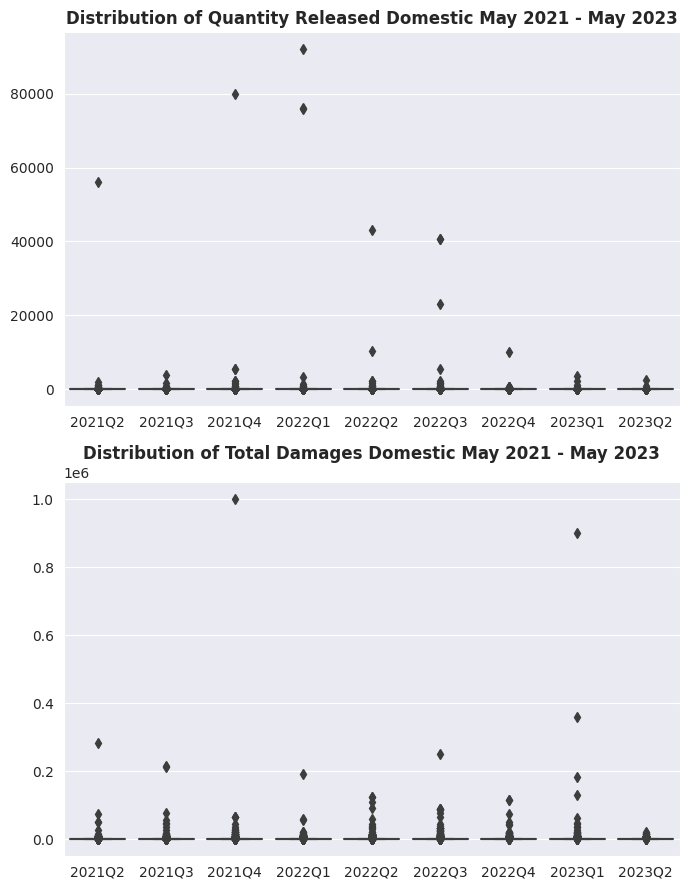

In [8]:
# size of plot figure
plt.figure(figsize=(7,9))
# loop through damages list
for i, dam in enumerate(damages):
  plt.subplot(2,1, i+1)
  sns.boxplot(data=shipping, x='quarter', y=dam)
  plt.title(f'Distribution of {dam} Domestic May 2021 - May 2023', weight='bold')
  plt.xlabel('')
  plt.ylabel('')

plt.tight_layout()
plt.show()

In [9]:
shipping[damages].describe()

,Quantity Released,Total Damages
count,48800.000000,48800.000000
mean,17.352842,705.437357
std,854.240538,7318.566860
min,0.000000,0.000000
25%,0.062500,0.000000
50%,0.375000,0.000000
75%,1.500000,0.000000
max,92000.000000,1000000.000000


 *Quantity Released* and *Total Damages* columns have a high number of large outliers.
 
 Interquartile Range (IQR) is the range where middle 50% of data lies in a boxchart.  Typically outliers are defined as any data points +/- 1.5 times IQR.

 Calculated Q1 and Q3 quantile values then subtract the different to calculate IQR.  Afterwards find outliers and then plot data without any outliers.

In [10]:
# create copy of shipping dataframe to avoid losing data in original dataframe
shipping_no_outlier=shipping.copy()
# calculate quartiles and IQR
Q1 = shipping_no_outlier[damages].quantile(0.25)
Q3 = shipping_no_outlier[damages].quantile(0.75)
IQR = Q3 - Q1

# create boolean mask of datapoints that are outliers and sum total.
total_outliers=((shipping[damages] < (Q1 - 1.5 * IQR)) | (shipping[damages] > (Q3 + 1.5 * IQR))).sum()
total_outliers

Quantity Released    8264
Total Damages        6099
dtype: int64

* There are 8264 outliers in *Quantity Released* column.
* There are 6099 outliers in *Total Damages* column.


In [11]:
# create boolean mask of datapoints that are outliers and sum total.
mask=((shipping[damages] < (Q1 - 1.5 * IQR)) | (shipping[damages] > (Q3 + 1.5 * IQR)))
shipping_no_outlier[mask]=np.nan

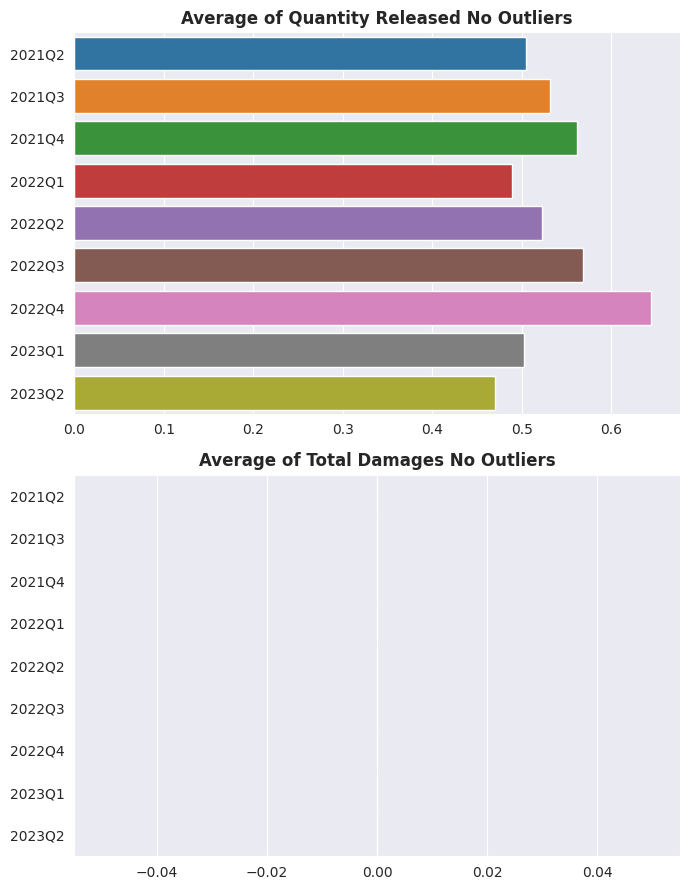

In [12]:
# size of plot figure
plt.figure(figsize=(7,9))
# loop through damages list
for i, dam in enumerate(damages):
  plt.subplot(2,1, i+1)
  sns.barplot(data=shipping_no_outlier, y='quarter', x=dam, errorbar=None)
  plt.title(f'Average of {dam} No Outliers', weight='bold')
  plt.xlabel('')
  plt.ylabel('')

plt.tight_layout()
plt.show()

* Once outliers are removed average quantity released drops to less than 0.7 gallons for all yearly quarters.  
* There are no damages once outliers are removed.  This shows that the original complete dataset was highly skewed.

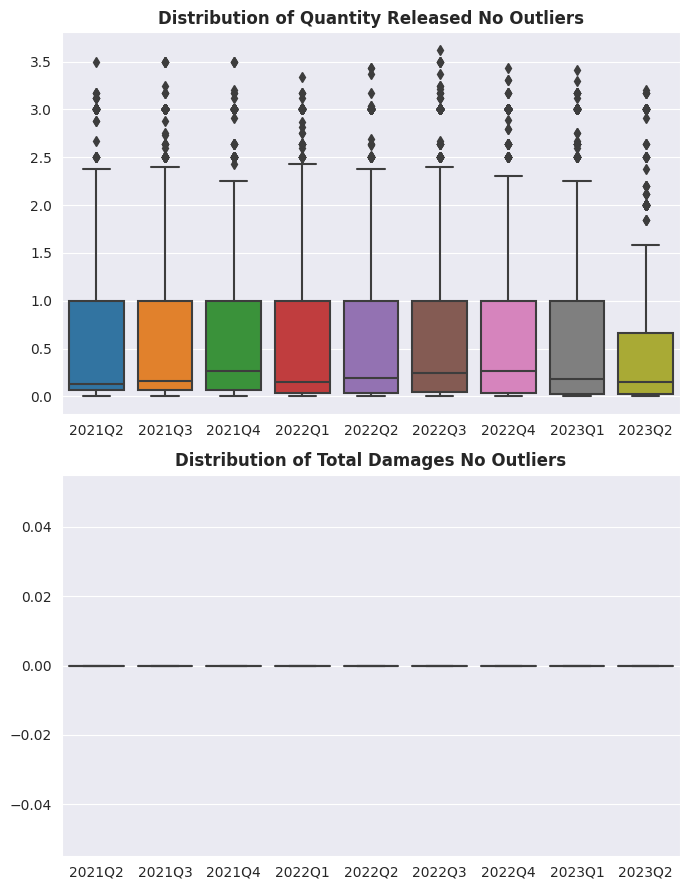

In [13]:
# size of plot figure
plt.figure(figsize=(7,9))
# loop through damages list
for i, dam in enumerate(damages):
  plt.subplot(2,1, i+1)
  sns.boxplot(data=shipping_no_outlier, x='quarter', y=dam)
  plt.title(f'Distribution of {dam} No Outliers', weight='bold')
  plt.xlabel('')
  plt.ylabel('')

plt.tight_layout()
plt.show()

* Quantity released in dataset with outliers removed peak at around 3.5 gallons.   
* Furthermore there are no damages once outliers are removed.

Next will look outliers isolated from rest of the dataset.

In [14]:
shipping_outliers=shipping.copy()
# creating removing datapoints
shipping_outliers[~mask]=np.nan

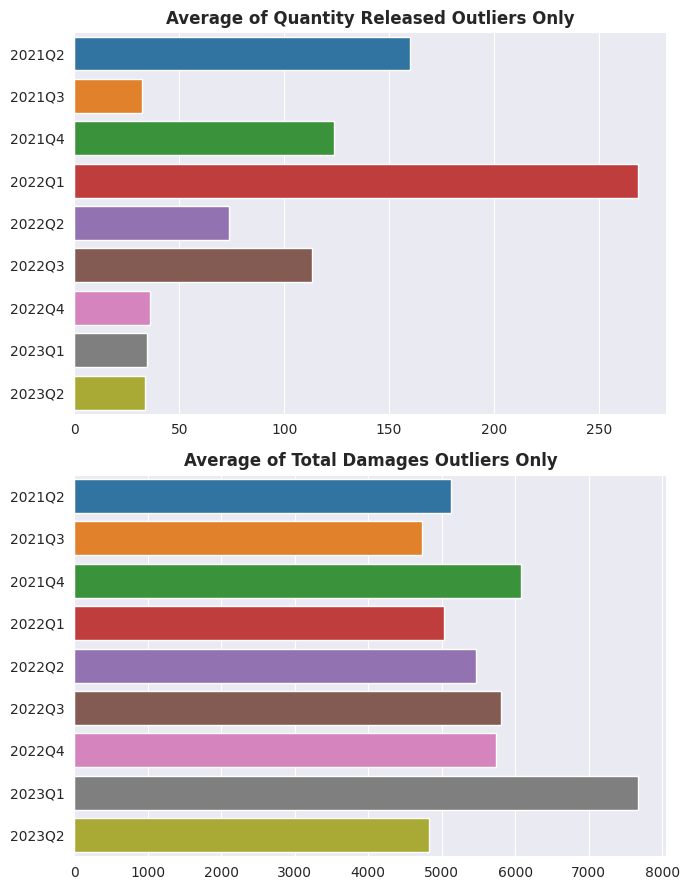

In [15]:
# size of plot figure
plt.figure(figsize=(7,9))
# loop through damages list
for i, dam in enumerate(damages):
  plt.subplot(2,1, i+1)
  sns.barplot(data=shipping_outliers, y='quarter', x=dam, errorbar=None)
  plt.title(f'Average of {dam} Outliers Only', weight='bold')
  plt.xlabel('')
  plt.ylabel('')

plt.tight_layout()
plt.show()

The vast majority of incidents results in no significant releases and no property damage, but once the event becomes more serious costs quickly escalate.


When you look at the outliers you can see the following:

* Average quantity released of the outliers range from about 35 gallons to over 250 gallons per yearly quarter.  There were likely a few very large releases in 2022Q1 that greatly skewed the mean.
* Averge damages amoungst the outliers range from around \$5,000 to \$8,000.

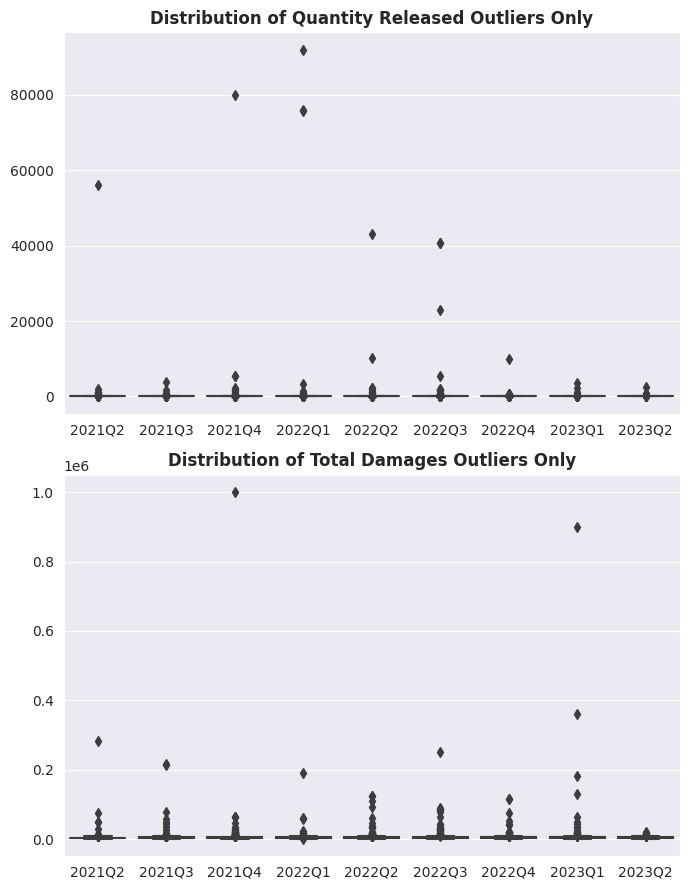

In [16]:
# size of plot figure
plt.figure(figsize=(7,9))
# loop through damages list
for i, dam in enumerate(damages):
  plt.subplot(2,1, i+1)
  sns.boxplot(data=shipping_outliers, x='quarter', y=dam)
  plt.title(f'Distribution of {dam} Outliers Only', weight='bold')
  plt.xlabel('')
  plt.ylabel('')

plt.tight_layout()
plt.show()

Even amoungst these outliers there are further outliers

* 7 Incidents with releases of 20,000 or more gallons occured during the two year period nationwide.
* 7 Incidents with costs of over \$200,000.

In [17]:
shipping_outliers[damages].describe()

,Quantity Released,Total Damages
count,8264.000000,6099.000000
mean,99.823235,5644.424168
std,2073.975529,20018.511698
min,3.698520,501.000000
25%,5.000000,3000.000000
50%,8.000000,4200.000000
75%,24.000000,5500.000000
max,92000.000000,1000000.000000


In [18]:
# list of different types of serious indicators
serious=['Serious Indicator', 'Serious Bulk Release', 'Serious Evacuations', 'Serious Radioactive', 'Major Artery Closed', 'Hazmat Injury Indicator', 'Fatalities Indicator']

# transforming data into numerical values
for s in serious:
  shipping[s]=shipping[s].apply(lambda x: 1 if x=='Yes' else 0)

In [19]:
# create empty dictionary 
serious_dic={}

# loop through serious list and fill empty dictionary with totals of each serious indicators
for s in serious:
  serious_dic[s]=shipping[s].sum()

serious_dic  

{'Serious Indicator': 314,
 'Serious Bulk Release': 263,
 'Serious Evacuations': 30,
 'Serious Radioactive': 0,
 'Major Artery Closed': 27,
 'Hazmat Injury Indicator': 22,
 'Fatalities Indicator': 1}

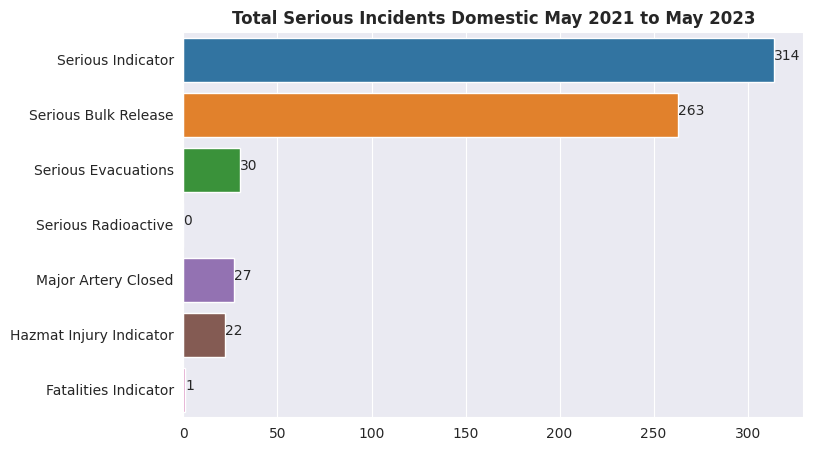

In [20]:
# figure size for barplot
plt.figure(figsize=(8,5))
# create barplot from dictionary filled with serious indicator totals
p=sns.barplot(y=list(serious_dic.keys()), x=list(serious_dic.values()))
plt.title('Total Serious Incidents Domestic May 2021 to May 2023', weight='bold')
# show actual values at end of each bar
show_values(p, orient='h')

There were only a total of 314 serious incidents over the two year period.  Of those incidents 263 involved a bulk release.  About 30 incidents involved evacuations; 27 incidents of highway closures and only 22 involved injuries with 1 fatatality.


Next will plot 'Incident Results' column.

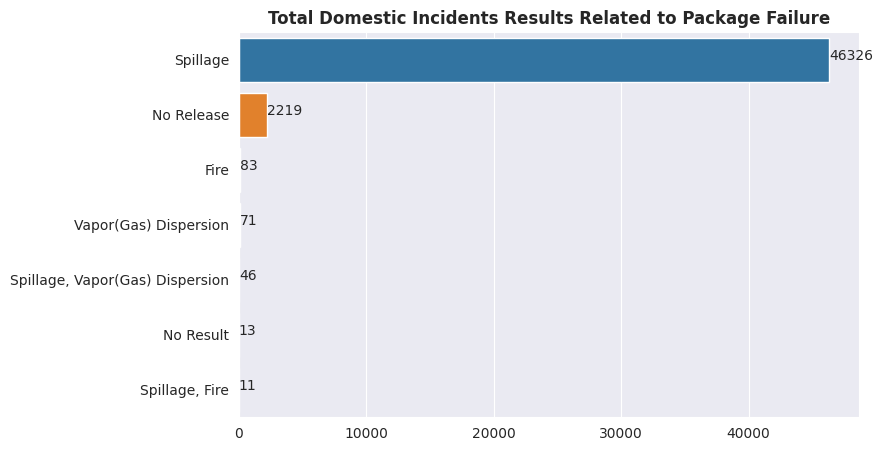

In [21]:
# size of plot figure
plt.figure(figsize=(8,5))
# dataset of top 7 'Incident Results'
inc_results=shipping['Incident Result'].value_counts().sort_values(ascending=False).head(7)
p=sns.barplot(x=inc_results, y=inc_results.index)
plt.title('Total Domestic Incidents Results Related to Package Failure', weight='bold')
plt.xlabel('')
show_values(p, orient='h')

The vast majority of incidents only results in spillage.



Next will plot container failure of single packaged vs double packaged shipments.

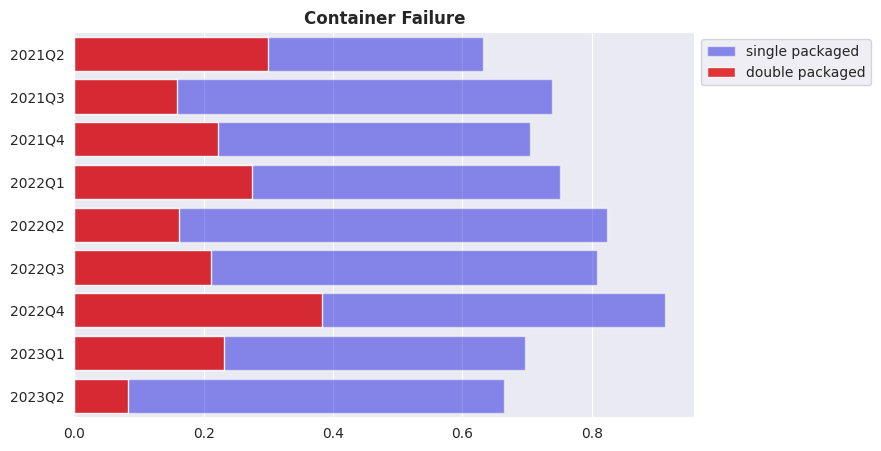

In [22]:
# size of figure plot
plt.figure(figsize=(8,5))
# two barplots overlapping each other. alpha=transparancy, label=name in legend
sns.barplot(data=shipping, y='quarter', x='Cont1 Pkg Shipment Nbr Failed', errorbar=None, alpha=0.5, color='blue', label='single packaged')
sns.barplot(data=shipping, y='quarter', x='Cont2 Pkg Shipment Nbr Failed', errorbar=None, alpha=0.9, color='red', label='double packaged')
plt.title('Container Failure', weight='bold')
plt.xlabel('')
plt.ylabel('')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True)
# location of legend outside plot
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

More container failures involved single packaged versus double packaged.

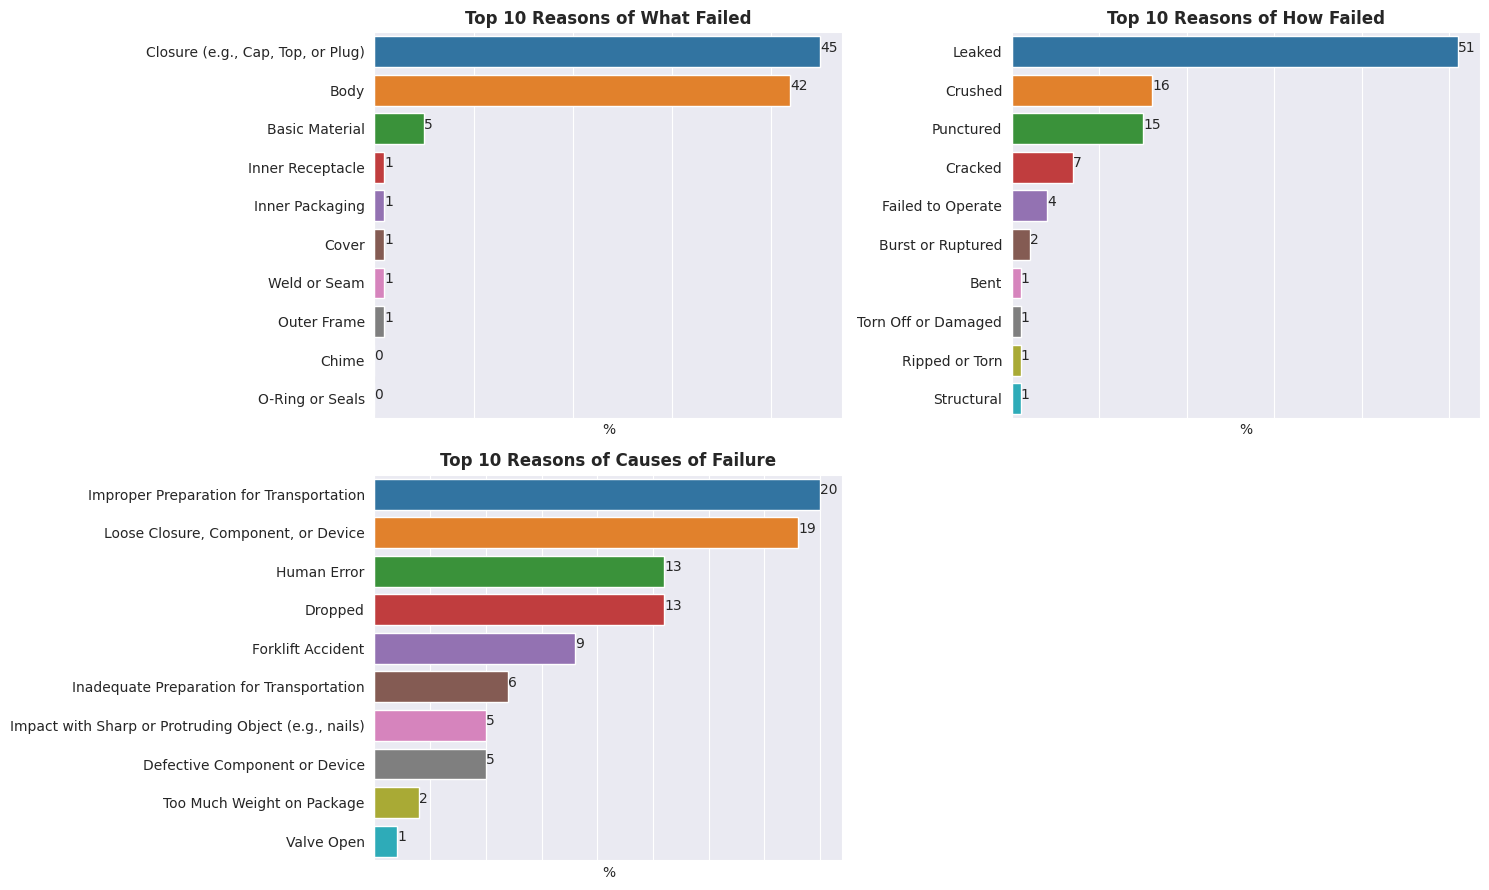

In [23]:
# list of failures
source_failure=['What Failed', 'How Failed', 'Causes of Failure']
# size of plot figure
plt.figure(figsize=(15,9))
for i, source in enumerate(source_failure):
  data=round(shipping[source].value_counts(normalize=True).sort_values(ascending=False).head(10)*100,0)
  # subplot first number=total rows in figure, second number=total columns in figure, third number= which subplot in figure
  plt.subplot(2,2,i+1)
  p=sns.barplot(x=data, y=data.index)
  plt.title(f'Top 10 Reasons of {source}', weight='bold')
  plt.xlabel('%')
  # remove x-ticks for readability
  plt.tick_params(axis='x',which='both',bottom=False, top=False, labelbottom=False)
  show_values(p, orient='h')
plt.tight_layout()
plt.show()  

* About 87% of *what failed* are either the closure or body.
* Over 50% of *how failed* are related to leaks
* Most causes of failure is due to human error whether it be by improper/inadequate preperation of shipment, general human error, dropped package or forklift accident.

<a id='Clean'></a>
## Initial Cleaning and Further Plots


Next a few initial columns will be removed for the following reasons:

* Serious Radioactive: No positive entries in dataset so column is has nothing to analyse
* Multiple Rows Per Incident: Only interested in individual rows.  Different rows will be treated individually to make overall data easier to understand.
* Incident Route: Data is nominal in nature and cannot easily converted to numerical or catagorical values.
* Commodity Long Name: long name of identification number.  Concentrating on overall hazard classes and not individual chemicals in analysis.
* Origin City: Has a lot of null values and is nominal in nature. 
* Carrier Reporter Name: Nominal data and cannot be broken into catagories.

In [24]:
# list of columns to drop
columns_drop=['Serious Radioactive', 'Multiple Rows Per Incident', 'Incident Route', 'Commodity Long Name', 'Origin City', 'Carrier Reporter Name']
shipping_modif=shipping.drop(columns=columns_drop)

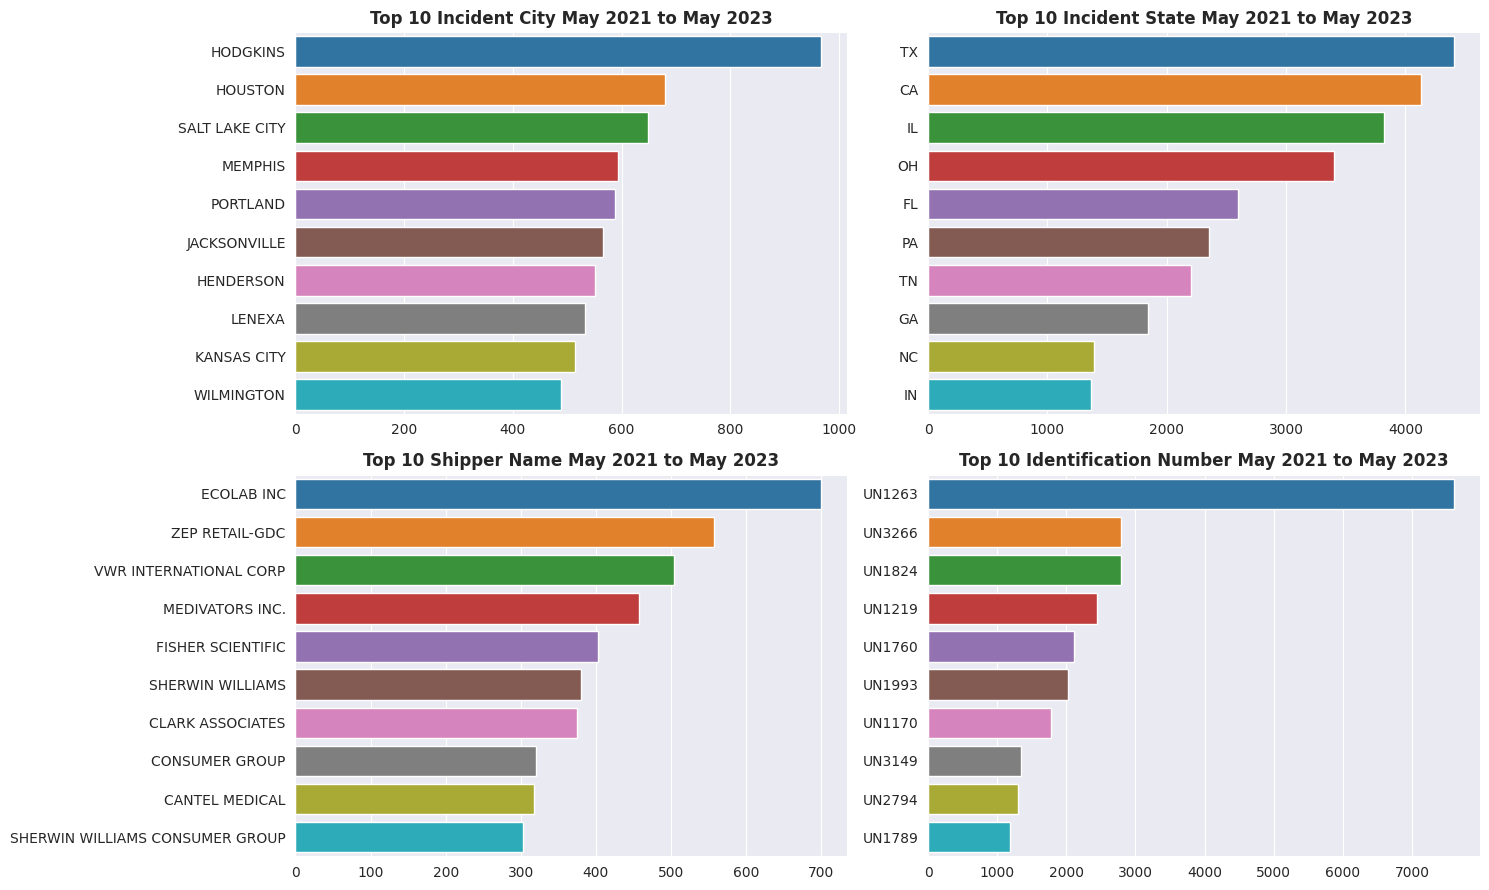

In [25]:
# list of geographical, shipper name and identification number columns
top_geo=['Incident City', 'Incident State', 'Shipper Name', 'Identification Number']

plt.figure(figsize=(15,9))

# enumerate through top_geo list and plot results
for i, top in enumerate(top_geo):
  plt.subplot(2,2,i+1)
  data=shipping_modif[top].value_counts().sort_values(ascending=False).head(10)
  sns.barplot(y=data.index, x=data)
  plt.title(f'Top 10 {top} May 2021 to May 2023', weight='bold')
  plt.xlabel('')
plt.tight_layout()
plt.show()

* [Hodgkins, Illinois](https://en.wikipedia.org/wiki/Hodgkins,_Illinois) is listed as the cit with the most shipping incidents.  Seeing as the town only has a population of 1500 it is likely a default hub of some sort where DOT lists spills throughout a large region.  The second higest amount of incidents are in Houston, Tx.
* Texas and California have the highest amount of incidents.
* Worst shipper violator is *Ecolab* and *Sherwin Williams* if you combine both *Sherwin Williams* bars together.
* [UN1263](https://www.hazmattool.com/info.php?b=UN1263) refers to paint, varnish, and other related materials and has the identifcation number for the largest number incidents.


Next will do a distribution plot of time incidents occured.

Text(0.5, 1.0, 'Distribution of Time Incidents Occured')

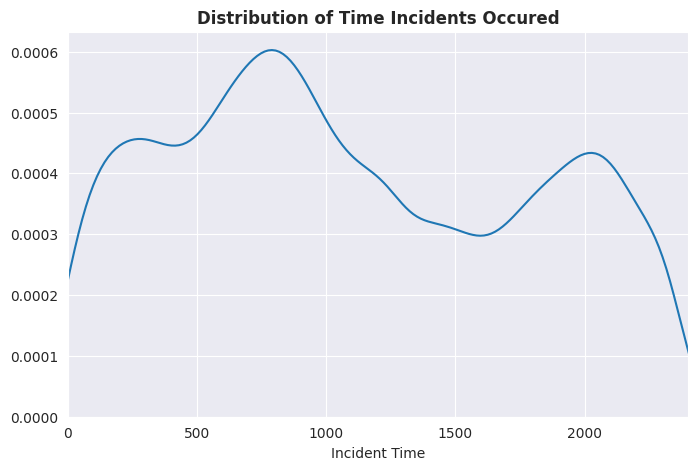

In [26]:
# size of figure plot
plt.figure(figsize=(8,5))

# kdeplot is related to a histogram but only traces the tops of where the histogram bars would be.
sns.kdeplot(data=shipping_modif, x='Incident Time')
# time is in 24 hour and not 12 hour format.  X-limit is set from 0 to 2400
plt.xlim(0,2400)
plt.ylabel('')
plt.title('Distribution of Time Incidents Occured', weight='bold')

Large peak during morning hours likely during preperation for deliveries that day.  Another peak at around 8:00pm likely during preperation for the next days shipments.

Text(0, 0.5, '')

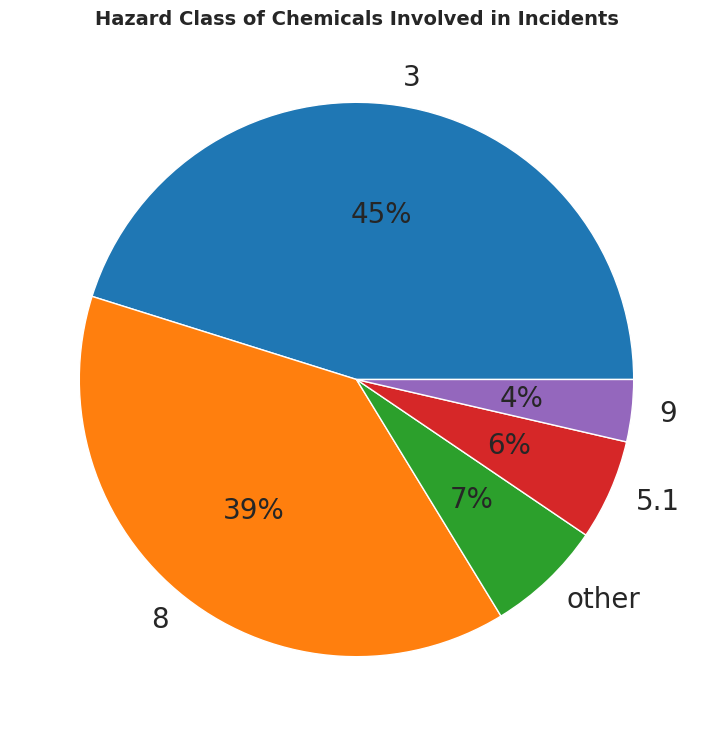

In [27]:
hazard_class_pie=shipping_modif['Hazardous Class']

# pool hazard classes with less incidents than class 9 as 'other' to increase readability
hazard_class_pie=hazard_class_pie.apply(lambda x: 'other' if x not in ['3','8','5.1','9'] else x)    
# size of figure of pie plot
plt.figure(figsize=(9,9))
hazard_class_pie.value_counts(normalize=True).plot.pie(autopct='%1.0f%%', fontsize=20)
plt.title('Hazard Class of Chemicals Involved in Incidents', weight='bold', size=14)
plt.ylabel('')


* About 84% of incidents involve corrosive or flammable materials


Text(0, 0.5, '')

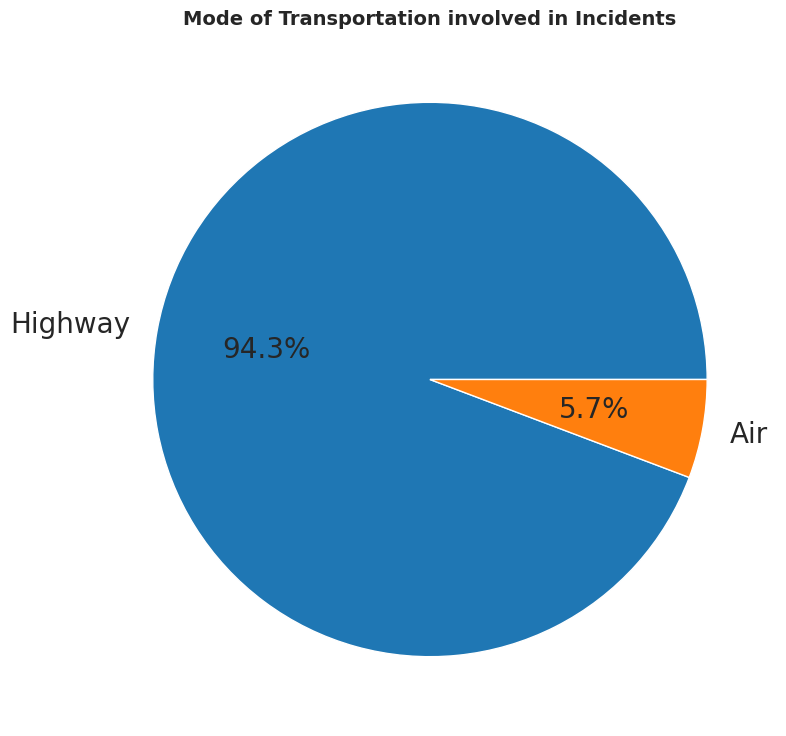

In [28]:
ship_trans=shipping_modif['Mode Of Transportation']
# water and rail both take up less than 0.3% total of dataset combined and will be ignored in piechart for readability
ship_trans=ship_trans.apply(lambda x: x if x in ['Highway', 'Air'] else np.nan)
plt.figure(figsize=(9,9))
ship_trans.value_counts(normalize=True).plot.pie(autopct='%1.1f%%', fontsize=20)
plt.title('Mode of Transportation involved in Incidents', weight='bold', size=14)
plt.ylabel('')

Vast majority of incidents are related to ground transportation with less than 6% involving air travel.

Dropping *incident city* and *report number* columns as they are nominal datapoints.  Also dropping all outcome variables except for 'Serious Indicator'  For purposes of this study all serious incidents will be treated the same to simplify overall analysis and make results easier to communicate.  

In [29]:
# selecting only columns I want to keep using iloc instead of listing out individual columns
new_shipping=shipping_modif.iloc[:,3:31]
new_shipping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48800 entries, 0 to 48799
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Date Of Incident                 48800 non-null  datetime64[ns]
 1   Incident Time                    48800 non-null  int64         
 2   Quantity Released                48800 non-null  float64       
 3   Unit Of Measure                  46558 non-null  object        
 4   Identification Number            48733 non-null  object        
 5   Hazardous Class                  48734 non-null  object        
 6   Total Hazmat Fatalities          48800 non-null  int64         
 7   Total Damages                    48800 non-null  int64         
 8   Shipper Name                     48797 non-null  object        
 9   Mode Of Transportation           48800 non-null  object        
 10  Identification Markings          30545 non-null  object   

Text(0.5, 1.0, 'Distribution of the Number of Words in Event Description')

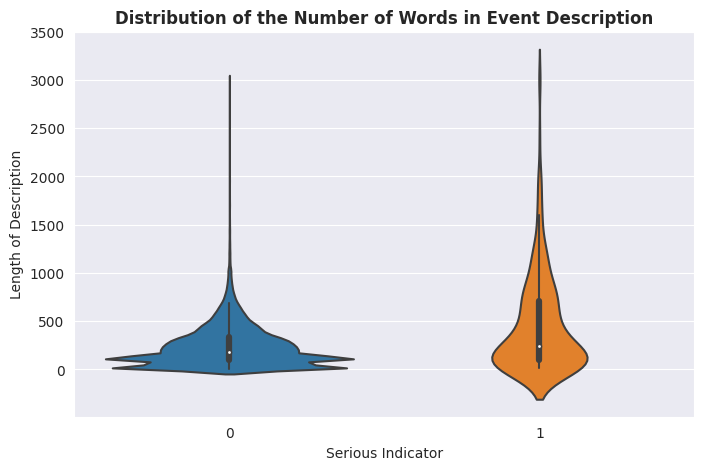

In [30]:
new_shipping['Length of Description']=new_shipping['Event Description'].str.len()
plt.figure(figsize=(8,5))
sns.violinplot(data=new_shipping, y='Length of Description', x=new_shipping['Serious Indicator'].astype(str))
plt.title('Distribution of the Number of Words in Event Description', weight='bold')

The number of words in *event descriptions* column for non-serious events tend to be smaller than the number of words in the *event description* column for serious incidents.  People are not likely to write long descriptions for relatively mudane incidents.  Because of this *Length of Description* variable functions more as an outcome variable than a predictive variable.

</br>

Next will attempt a different approach to transform the *Event Description* column into more predictive numerical values.  The next approach will be to compare the frequencies of words in the *event description* of serious events vs the frequencies in non-serious incident descriptions.  This approach is similar to how SPAM filters typically work.

<a id='WordCloud'></a>
## Word Cloud Generation

A word cloud is a technique to visualize the frequencies of words found in a text field.  The first step is to vectorize words in the description using [TfidVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).  Afterwards will convert the resulting vector into a dataframe and then order words found in the description of serious events by order of frequency.  

</br>
Next compare the frequency of how often the top 200 words found in the description of serious events occur in non-serious events.  The reason 200 words where chosen is that using anymore requires too much computer resources and at some point having a vocabulary too large is just the rough equivalent of going by the length of description.

In [31]:
new_shipping=new_shipping.drop(columns='Length of Description')
new_shipping['Event Description']=new_shipping['Event Description'].str.lower()
# isolate comments from rows with serious indicator
serious_description=new_shipping[new_shipping['Serious Indicator']==1]['Event Description']


In [32]:
# vectorizer=TfidfVectorizer(stop_words='english', ngram_range=(1,1), max_df=0.6, min_df=0.01)
vectorizer=TfidfVectorizer(stop_words='english')
X=vectorizer.fit_transform(serious_description)


In [33]:
# create dense matrix to convert into list and then into dataframe
feature_names = vectorizer.get_feature_names_out()
# Return a dense matrix representation of this matrix.
dense=X.todense()
# transform matrix to list
denselist=dense.tolist()
# create dataframe from denselist with columns by feature namese
serious_words=pd.DataFrame(denselist, columns=feature_names)
serious_words.head()

,00,000,000lbs,0051,01,0130,02,0220,0245,0249,...,xpo,xsg,xsw,yard,yards,yellow,york,young,zinc,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# transpose array with indiviudual words as the index, columns are serious incidents
trans_ser=serious_words.transpose()

# create column for sum of words
trans_ser['sum']=trans_ser.sum(axis=1)
trans_ser.sort_values('sum', ascending=False).head(10)

,0,1,2,3,4,5,6,7,8,9,...,305,306,307,308,309,310,311,312,313,sum
freight,0.0,0.0,0.000000,0.164909,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.143974,0.0,24.571971
forklift,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.123630,0.0,0.127793,0.000000,0.000000,0.000000,0.000000,0.0,18.222236
product,0.0,0.0,0.000000,0.126768,0.0,0.0,0.0,0.000000,0.285031,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,15.515154
tote,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.166104,0.0,...,0.0,0.224167,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,15.367293
release,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.026653,0.000000,0.107905,0.0,14.410536
associate,0.0,0.0,0.000000,0.180424,0.0,0.0,0.0,0.262517,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,14.077680
causing,0.0,0.0,0.000000,0.163932,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.070703,0.000000,0.000000,0.0,13.692076
damage,0.0,0.0,0.339898,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.078996,0.0,0.000000,0.035335,0.000000,0.000000,0.000000,0.0,12.396204
properly,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.155371,0.0,12.098756
trailer,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.396335,0.0,0.058526,0.000000,0.096571,0.252403,0.000000,0.0,11.758814


In [35]:
# find top 100 words in rows by serious indicator
top_200_danger=trans_ser.sort_values('sum', ascending=False).head(200)
top_200_index=top_200_danger.index
top_200_index

Index(['freight', 'forklift', 'product', 'tote', 'release', 'associate',
       'causing', 'damage', 'properly', 'trailer',
       ...
       'occurred', 'cut', 'absorbent', 'sodium', 'igniting', 'tractor', '200',
       'secured', 'dg', 'generated'],
      dtype='object', length=200)

Create [Word Cloud](https://github.com/amueller/word_cloud) using frequencies of words.

(-0.5, 399.5, 199.5, -0.5)

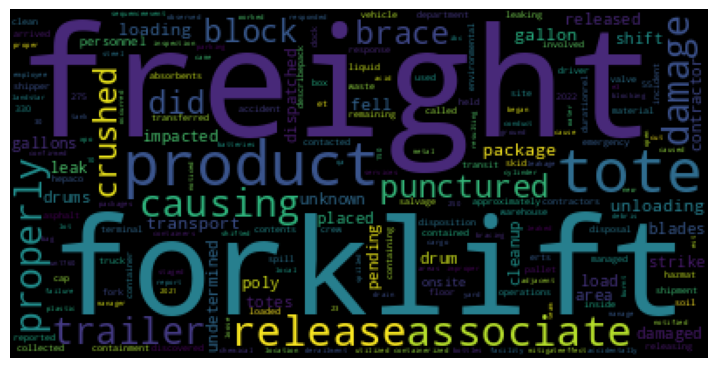

In [36]:
# generate word cloud from frequencies
wordcloud = WordCloud().generate_from_frequencies(trans_ser['sum'])
plt.figure(figsize=(9,9))
plt.imshow(wordcloud)
plt.grid()
plt.axis("off")

In [37]:
# create mask from image of truck
truck_mask = np.array(Image.open("/content/drive/MyDrive/truck_mask.png"))

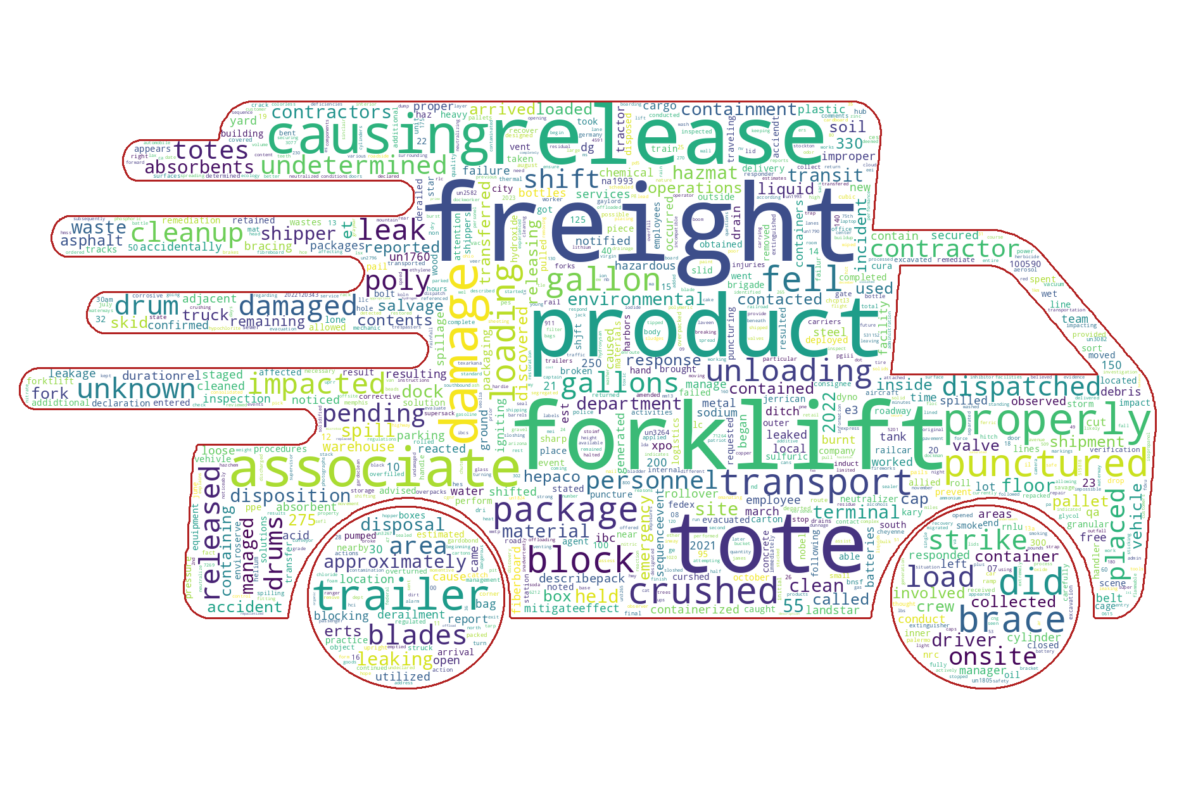

In [38]:
# create wordcloud object with truck mask
wc=WordCloud(background_color='white', max_words=1000, mask=truck_mask, contour_width=3, contour_color='firebrick')
# fit object with frequencies of words.
wc.generate_from_frequencies(trans_ser['sum'])

# plot image
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Now that the word clouds have been created from *Event Description* of serious incidents.  Using the top 200 words as a vocabulary when analyzing the *Event Description* of non-serious incidents we will be able to make quantitative comparisons.  

<br>

Next fit *Event Description* to TfidVectorizer with top_200_index created from top 200 words found in the *Event Description* of serious incidents to all incidents.

In [39]:
new_shipping['Event Description']=new_shipping['Event Description'].fillna('No_Comment')
vectorizer=TfidfVectorizer(stop_words='english', vocabulary=top_200_index)
X=vectorizer.fit_transform(new_shipping['Event Description'])

# vectorize all event descriptions in dataset
feature_names = vectorizer.get_feature_names_out()
dense=X.todense()
denselist=dense.tolist()
event_words=pd.DataFrame(denselist, columns=feature_names)
event_words

,freight,forklift,product,tote,release,associate,causing,damage,properly,trailer,...,occurred,cut,absorbent,sodium,igniting,tractor,200,secured,dg,generated
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48795,0.0,0.0,0.0,0.305876,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48796,0.0,0.0,0.0,0.188991,0.0,0.0,0.168109,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48797,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48798,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.302395,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Create new column for red flags.  Red Flags are any of the top 200 most frequent words that appear in *Event Description* of serious incidents.

In [40]:
# red flags calculated from sums in event_words dataframe
new_shipping['Frequency of Red Flags']=event_words.sum(axis=1)
# create table comparing frequencies of red flags
new_shipping.groupby('Serious Indicator')['Frequency of Red Flags'].describe().transpose()

Serious Indicator,0,1
count,48486.000000,314.000000
mean,2.669423,3.287628
std,1.224545,1.415680
min,0.000000,0.000000
25%,1.725228,2.344325
50%,3.064385,3.221032
75%,3.451170,4.124405
max,6.927106,6.755767


Text(0.5, 1.0, 'Distribution of Red Flags')

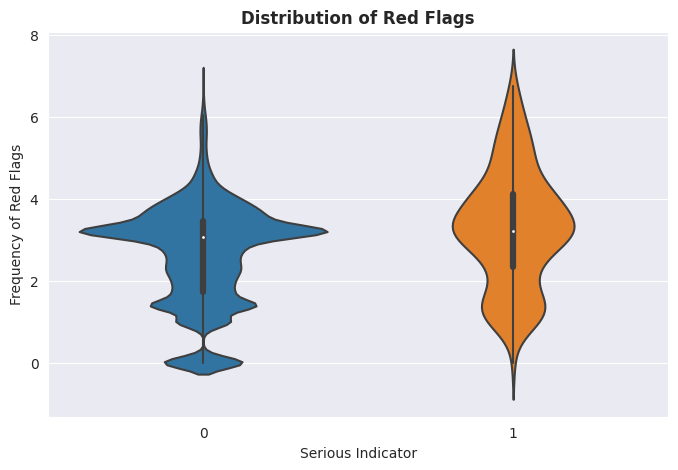

In [41]:
# size of figure plot
plt.figure(figsize=(8,5))
# create violin plot for comparing distributions
sns.violinplot(data=new_shipping, y='Frequency of Red Flags', x='Serious Indicator')
plt.title('Distribution of Red Flags', weight='bold')

Overall the *Event Description* in non-serious events tend to have less *Red Flags* than serious incidents.  

* The *Red Flags* Median of non-serious incidents is fairly close to the median of serious incidents.  
* High distribution of *Red Flgas* relating to non_serious incidents is highly concentrated at about three words.  While distributions of serious incidents are more spread out.
* There is a medium distribution of *Red Flags* at 0 for non-serious incidents.  There are very few serious incidents with 0 *Red Flags*.


The assumption going forward is that increased red flags is roughly correlated to carelessness of the packaging and transportation of hazardous materials.

<a id='Prep'></a>
## Data Preperation for Correlations and Decision Tree Analysis

In order to do further analysis variables in dataset need to be converted to numerical values.  Catagorical features can be converted to [dummy variables](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).

First will consolidate catagories wherever possible.

In [42]:
# print value counts of Hazardous Classes
new_shipping['Hazardous Class'].value_counts()

3        22035
8        18824
5.1       2863
9         1764
2.2       1035
6.1        626
2.1        514
5.2        462
4.1        149
2.0        119
1.4S       112
1.4         98
4.2         38
6.2         37
4.3         15
1.4G        11
2.3         11
ORM-D        8
1.4C         4
1.1D         3
1.3C         2
1.4B         1
1.4D         1
7            1
1.1G         1
Name: Hazardous Class, dtype: int64

In [43]:
# Renaming and consolidating hazard catagories in column with dictionary
hazard_dict={'3': 'Flammable', '8': 'Corrosive', '5.1': 'Oxidizers', '9': 'Miscellaneous', '2.2': 'Non-Flammable Gas', '6.1': 'Toxic', '2.1': 'Flammable Gas', '5.2': 'Organic Peroxides', '4.1': 'Flammable Solids', '2.0': 'Compressed Gas', '1.4S': 'Explosive', 
             '1.4':'Explosive', '4.2': 'Spontaneously Combustible', '6.2': 'Infectious Substance', '4.3': 'Dangerous When Wet', '1.4G': 'Explosive', '2.3': 'Poisonous gas', '1.4C': 'Explosive', '1.1D': 'Explosive', '1.3C': 'Explosive', '1.4B': 'Explosive', '1.4D': 'Explosive', 
             '7': 'Radioactive Materials', '1.1G': 'Explosive'}
# mapping dictionary to column and printing new value counts
new_shipping['Hazardous Class']=new_shipping['Hazardous Class'].map(hazard_dict)
new_shipping['Hazardous Class'].value_counts()             

Flammable                    22035
Corrosive                    18824
Oxidizers                     2863
Miscellaneous                 1764
Non-Flammable Gas             1035
Toxic                          626
Flammable Gas                  514
Organic Peroxides              462
Explosive                      233
Flammable Solids               149
Compressed Gas                 119
Spontaneously Combustible       38
Infectious Substance            37
Dangerous When Wet              15
Poisonous gas                   11
Radioactive Materials            1
Name: Hazardous Class, dtype: int64

Creating new column for packages that are double packaged versus single packaged.  The assumption is that packages without *Cont2 Material Type* not filled in is a single package and will be given a value of 0.  Packages that are double packaged will be given a value of 1.

In [44]:
# creating new column for packages that are double packaged.  If Cont2 i
new_shipping['Double Packaged']=new_shipping['Cont2 Material Type'].apply(lambda x: 0 if x is np.nan else 1)
new_shipping['Double Packaged'].value_counts()

0    41458
1     7342
Name: Double Packaged, dtype: int64

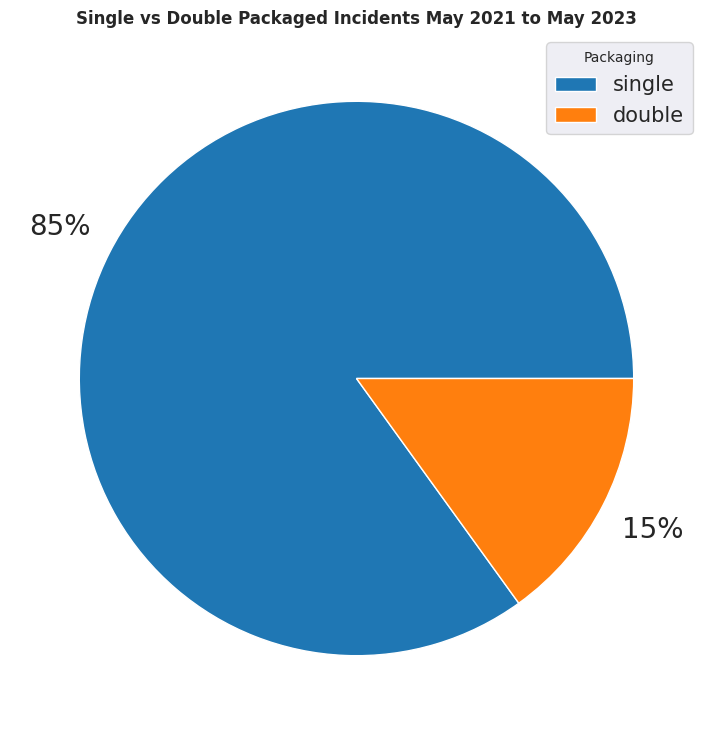

In [45]:
# size of plot
plt.figure(figsize=(9,9))
# create pie plot using data from 'Double Packaged' column in dataframe
new_shipping['Double Packaged'].value_counts(normalize=True).plot.pie(autopct='%1.0f%%', labeldistance=None, fontsize=20, pctdistance=1.2)
# title and legend setup and removal of ylabel for readability
plt.title('Single vs Double Packaged Incidents May 2021 to May 2023', weight='bold', size=12)
plt.ylabel('')
plt.legend(labels=['single','double'], title='Packaging', fontsize=15)

Top five values in columns *What Failed, How Failed, Causes of Failure* will not change but every other values will be consolidated into an *Other* catagory.  Cannot have resulting datset with too many variables/features as analysis will become more difficult and would take too many computer resources.  

In [46]:
top_five_what_failed=new_shipping['What Failed'].value_counts().head(5).index

new_shipping['What Failed']=new_shipping['What Failed'].apply(lambda x: 'Other' if x not in top_five_what_failed else x)

In [47]:
new_shipping['What Failed'].value_counts().head(6)

Closure (e.g., Cap, Top, or Plug)    17496
Body                                 16341
Other                                11890
Basic Material                        2076
Inner Receptacle                       565
Inner Packaging                        432
Name: What Failed, dtype: int64

In [48]:
top_five_how_failed=new_shipping['How Failed'].value_counts().head(5)

new_shipping['How Failed']=new_shipping['How Failed'].apply(lambda x: 'Other' if x not in top_five_how_failed else x)

new_shipping['How Failed'].value_counts().head(10)

Leaked               19470
Other                13268
Crushed               6223
Punctured             5705
Cracked               2671
Failed to Operate     1463
Name: How Failed, dtype: int64

In [49]:
top_five_causes=new_shipping['Causes of Failure'].value_counts().head(5)

new_shipping['Causes of Failure']=new_shipping['Causes of Failure'].apply(lambda x: 'Other' if x not in top_five_causes else x)

new_shipping['Causes of Failure'].value_counts().head(6)

Other                                      20579
Improper Preparation for Transportation     7493
Loose Closure, Component, or Device         7297
Human Error                                 5114
Dropped                                     4920
Forklift Accident                           3397
Name: Causes of Failure, dtype: int64

Dropping following columns:

* Date of Incident: Specific dates not needed for overall analysis.
* Unit of Measure: Majority of UOM are in gallons.  Converting other UOM is difficult without knowing the various densities.  Just need relative values to one another.
* Shipper name: Too many different catagories to be made useful with dummy variables
* Identification Markings: Chemical catagories are already broadly covered by *Hazard Catagory.*
* Event Description: Already converted to numerical values using *Red Flags* column already created.

In [50]:
col_drop=['Date Of Incident', 'Unit Of Measure', 'Identification Number', 'Shipper Name', 'Identification Markings', 'Cont1 Package Capacity Uom', 'Cont2 Capacity Uom Reported', 'Event Description']
# create new dateset after column drop incase need to go back to earlier state
test_ship=new_shipping.drop(columns=col_drop)

In [51]:
test_ship['Cont1 Material Of Construction'].value_counts()

Fiberboard                            23832
Plastic                               10831
Metal other than steel or aluminum     5489
Steel                                  2917
Paper, multi-wall                       845
Aluminum                                204
Metal                                   109
Natural Wood                             64
Textile                                  58
Composite                                23
Plywood                                  21
Flexible                                 10
Reconsituted Wood                         8
Wooden                                    6
Glass, procelain, or stoneware            1
Name: Cont1 Material Of Construction, dtype: int64

In [52]:
# converting catagories not in top 5 to 'Other.'
top_five_cont1_mat=test_ship['Cont1 Material Of Construction'].value_counts().head(5)
test_ship['Cont1 Material Of Construction']=test_ship['Cont1 Material Of Construction'].apply(lambda x: 'Other' if x not in top_five_cont1_mat else x)
test_ship['Cont1 Material Of Construction'].value_counts()

Fiberboard                            23832
Plastic                               10831
Metal other than steel or aluminum     5489
Other                                  4886
Steel                                  2917
Paper, multi-wall                       845
Name: Cont1 Material Of Construction, dtype: int64

In [53]:
# only 8 different catagories no change needed
test_ship['Cont1 Packaging Type'].value_counts()

Box                    26121
Drum                   10517
Jerrican                4631
Bag                     1481
IBC                     1347
Pressure receptacle      198
Composite Packaging      126
Wooden Barrel              9
Name: Cont1 Packaging Type, dtype: int64

In [54]:
# only 5 different catagories no change needed
test_ship['Cont2 Material Type'].value_counts()

Plastic                           4817
Metal (any type)                  1858
Glass, procelain, or stoneware     478
Fiberboard or cardboard            185
Wood (any type)                      4
Name: Cont2 Material Type, dtype: int64

In [55]:
# only 5 different catagories no change needed
test_ship['Cont2 Package Type'].value_counts()

Bottle      4782
Can         1708
Box          279
Bag          183
Cylinder     148
Name: Cont2 Package Type, dtype: int64

In [56]:
# convert catagorical columns into dummy variables
test_ship=pd.get_dummies(test_ship)
test_ship.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48800 entries, 0 to 48799
Data columns (total 75 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   Incident Time                                                      48800 non-null  int64  
 1   Quantity Released                                                  48800 non-null  float64
 2   Total Hazmat Fatalities                                            48800 non-null  int64  
 3   Total Damages                                                      48800 non-null  int64  
 4   Cont1 Package Capacity                                             48800 non-null  float64
 5   Cont1 Shipment Nbr                                                 48800 non-null  int64  
 6   Cont1 Pkg Shipment Nbr Failed                                      48800 non-null  int64  
 7   Cont2 Package Capacity

In [57]:
test_ship[['Mode Of Transportation_Rail', 'Mode Of Transportation_Water']].value_counts()

Mode Of Transportation_Rail  Mode Of Transportation_Water
0                            0                               48670
1                            0                                 116
0                            1                                  14
dtype: int64

There are now 75 variables.  Need to remove excess features/variables from dataset before decision tree analysis can be performed.

Dropping the following columns:

* Total Hazmat Fatalities: outcome variable cannot be used for prediction purposes
* Hazardous Class_Radioactive Materials: Only 1 reported incident in two year period.  Too rare to be useful.
* Cont1 Packaging Type_Wooden Barrel: Only involved in 9 incidents: Too rare to be useful.
* Mode of Transportation_Rail: Too rare to be useful.
* Any 'Other' Catagories: Too broad of catagories to be useful.  Only using top 5 of related catagories.

In [58]:
col_drop=['Total Hazmat Fatalities', 'Hazardous Class_Radioactive Materials', 'Cont1 Packaging Type_Wooden Barrel',  'Mode Of Transportation_Rail', 'What Failed_Other', 'How Failed_Other', 'Cont1 Material Of Construction_Other', 
          'Cont2 Material Type_Wood (any type)', 'Causes of Failure_Other', ]

test_ship=test_ship.drop(columns=col_drop)
test_ship.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48800 entries, 0 to 48799
Data columns (total 66 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   Incident Time                                                      48800 non-null  int64  
 1   Quantity Released                                                  48800 non-null  float64
 2   Total Damages                                                      48800 non-null  int64  
 3   Cont1 Package Capacity                                             48800 non-null  float64
 4   Cont1 Shipment Nbr                                                 48800 non-null  int64  
 5   Cont1 Pkg Shipment Nbr Failed                                      48800 non-null  int64  
 6   Cont2 Package Capacity Reported                                    48800 non-null  float64
 7   Cont2 Shipment Nbr    

In [59]:
# changing datatypes to datatypes with smaller footprints
test_ship['Serious Indicator']=test_ship['Serious Indicator'].astype(np.uint8)
test_ship['Double Packaged']=test_ship['Double Packaged'].astype(np.uint8)

In [60]:
# Nbr refers to individual packages per shipment
test_ship[['Cont1 Shipment Nbr', 'Cont1 Pkg Shipment Nbr Failed', 'Cont2 Shipment Nbr', 'Cont2 Pkg Shipment Nbr Failed']].describe()

,Cont1 Shipment Nbr,Cont1 Pkg Shipment Nbr Failed,Cont2 Shipment Nbr,Cont2 Pkg Shipment Nbr Failed
count,48800.000000,48800.000000,48800.000000,48800.000000
mean,5.093525,0.762828,2.964119,0.225225
std,42.512475,6.373031,99.694146,6.608634
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000
max,4670.000000,1121.000000,15126.000000,1303.000000


Dropping due to prevelance of data not being recorded and large standard deviation.

* Cont1 Shipment Nbr
* Cont 1 Pkg Shipment Nbr Failed
* Cont2 Shipment Nbr
* Cont2 Pkg Shipment Nbr Failed

In [61]:
col_drop=['Cont1 Shipment Nbr', 'Cont1 Pkg Shipment Nbr Failed', 'Cont2 Shipment Nbr', 'Cont2 Pkg Shipment Nbr Failed']
test_ship=test_ship.drop(columns=col_drop)
test_ship.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48800 entries, 0 to 48799
Data columns (total 62 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   Incident Time                                                      48800 non-null  int64  
 1   Quantity Released                                                  48800 non-null  float64
 2   Total Damages                                                      48800 non-null  int64  
 3   Cont1 Package Capacity                                             48800 non-null  float64
 4   Cont2 Package Capacity Reported                                    48800 non-null  float64
 5   Serious Indicator                                                  48800 non-null  uint8  
 6   Frequency of Red Flags                                             48800 non-null  float64
 7   Double Packaged       

<a id='Corr'></a>
## Correlations of Various Features Associated with Serious Incidents

Now that data has been converted to numerical values it is now possible to look at correlations relating to serious incidents.  Using [**pearson standard correlation coefficient**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html).  Afterwards will drop any columns with less than 1% correlation with serious incidents.

In [62]:
# creating correlations dataframe
correlations=abs(test_ship.drop(columns=damages).corr())
# sort values by Serious Indicator
correlations=correlations.sort_values('Serious Indicator', ascending=False)
# creating correlations dataframe only relating to Serious Indicator
serious_correlations=correlations['Serious Indicator']
serious_correlations

Serious Indicator                                                    1.000000
Cont1 Packaging Type_IBC                                             0.227350
Cont1 Package Capacity                                               0.113202
Hazardous Class_Compressed Gas                                       0.063573
Cont1 Material Of Construction_Plastic                               0.062481
Cont1 Material Of Construction_Fiberboard                            0.055037
Cont1 Packaging Type_Box                                             0.051423
What Failed_Closure (e.g., Cap, Top, or Plug)                        0.044130
How Failed_Leaked                                                    0.043062
Hazardous Class_Flammable                                            0.042633
Frequency of Red Flags                                               0.040290
How Failed_Punctured                                                 0.036126
Hazardous Class_Miscellaneous                                   

Text(0.5, 0, '')

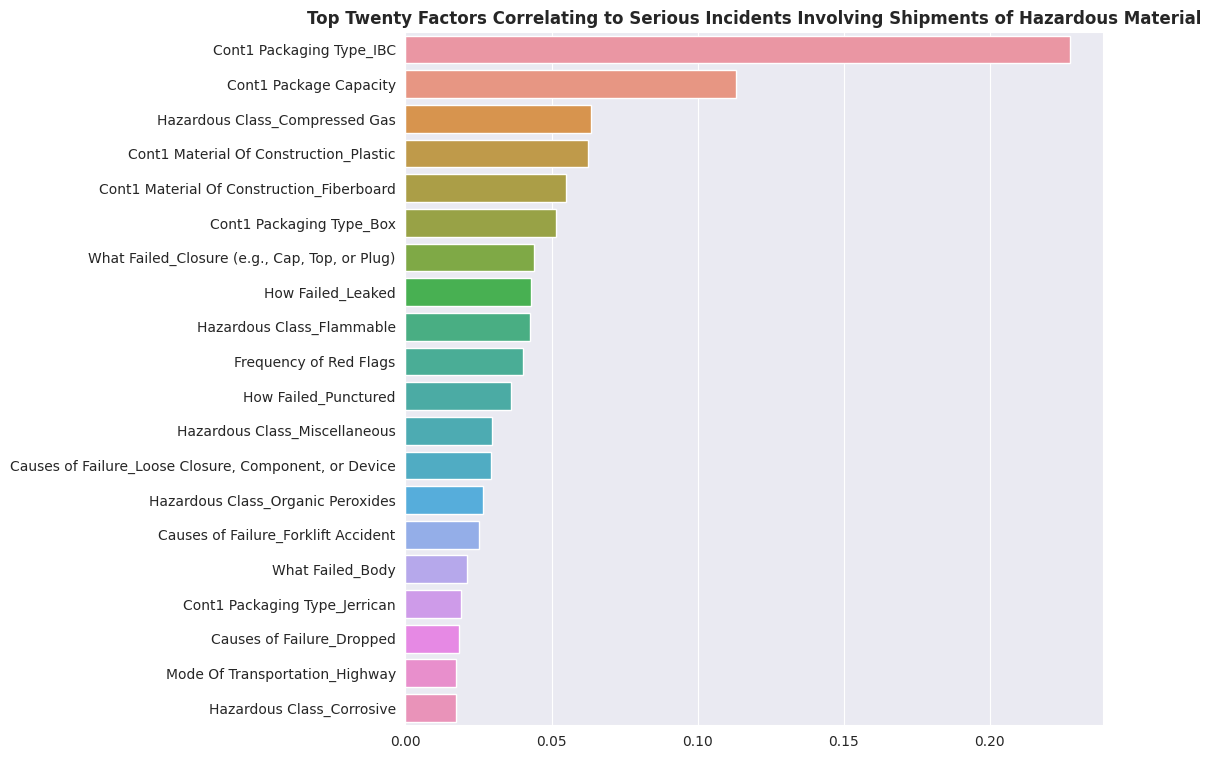

In [63]:
# plot top twenty factors
plt.figure(figsize=(9,9))
sns.barplot(y=serious_correlations.iloc[1:].head(20).index, x=serious_correlations.iloc[1:].head(20))
plt.title('Top Twenty Factors Correlating to Serious Incidents Involving Shipments of Hazardous Material', weight='bold')
plt.xlabel('')

**Overall Patterns in Correlations**

* Larger shipments tend to be more dangerous
* Shipping of Compressed Gas has high correlations with serious incidents
* Plastic Containers tend to have higher correlation than  fiberboard.  This is likely because single plastic containers tend to be filled with liquid such as bottles of bleach and if container is damaged will be very prone to leaks without any secondary containment. 
* Hazard Classes Flammable, Organic Peroxides and Corrosive have high correlation with serious incidents.
* High correlation of serious incidents involved container failure such as leaks and failed closures.
* Human Error related factors such as punctures, forklift accidents and dropped packages have high correlation.

Features that will be used going forward are any variables with a 1% correlation with 'Serious Incidents' or higher.

In [64]:
# dropping columns with correlation less than 1% 
correlations_mask=serious_correlations.mask(serious_correlations<0.01).dropna()
# using only columns that match index of correlations_mask
test_ship=test_ship[correlations_mask.index]
# rejoining columns related to damages to dataset incase needed in future
test_ship=test_ship.join(new_shipping[damages])
test_ship.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48800 entries, 0 to 48799
Data columns (total 33 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   Serious Indicator                                                  48800 non-null  uint8  
 1   Cont1 Packaging Type_IBC                                           48800 non-null  uint8  
 2   Cont1 Package Capacity                                             48800 non-null  float64
 3   Hazardous Class_Compressed Gas                                     48800 non-null  uint8  
 4   Cont1 Material Of Construction_Plastic                             48800 non-null  uint8  
 5   Cont1 Material Of Construction_Fiberboard                          48800 non-null  uint8  
 6   Cont1 Packaging Type_Box                                           48800 non-null  uint8  
 7   What Failed_Closure (e

<a id='Dec'></a>
## Decision Tree Analysis

![pic](https://dpbnri2zg3lc2.cloudfront.net/en/wp-content/uploads/old-blog-uploads/decision-tree-examples.jpg)
[source](https://careerfoundry.com/en/blog/data-analytics/what-is-a-decision-tree/)



Next will use the prepared data to run [decision tree analysis](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).  The purpose of this analysis is to see what likely chains of events lead to serious incidents.  


Complete decision trees tend to be difficult to read unless max depth is restrained.  To balance between readability and amount of information conveyed all created decision trees will be limited to a max_depth of four.


Because the dataset is greatly imbalanced between serious and nonserious incidents for purposes of decision tree analysis nonserious incidents will be undersampled.


In [65]:
# seperate datasets by serious indicator
serious_df=test_ship[test_ship['Serious Indicator']==1]

non_serious_df=test_ship[test_ship['Serious Indicator']==0]

print(serious_df.shape, non_serious_df.shape)

(314, 33) (48486, 33)


In [66]:
# sample of 20% of total non_serious_df
sample=non_serious_df.copy().sample(frac=0.2, random_state=53)

# combining sample df and serious df
combined_serious_sample=pd.concat([sample, serious_df], axis=0)

In [67]:
# dropping outcome variables
combined_serious_sample=combined_serious_sample.drop(columns=damages)

In [68]:
# create Serious column for labeling purposes in tree.
combined_serious_sample['Serious']=combined_serious_sample['Serious Indicator'].apply(lambda x: 'serious' if x==1 else 'not_serious')
# drop Serious Indicator column as data is now covered by Serious column
combined_serious_sample=combined_serious_sample.drop(columns='Serious Indicator')

In [69]:
combined_serious_sample['Serious'].value_counts()

not_serious    9697
serious         314
Name: Serious, dtype: int64

In [70]:
# split predictor variables from outcome variable
X_train=combined_serious_sample.drop(columns='Serious')
y_train=combined_serious_sample['Serious']
# create decision tree classifier object
clf=tree.DecisionTreeClassifier(max_depth=4)
# fit data to tree
clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=4)

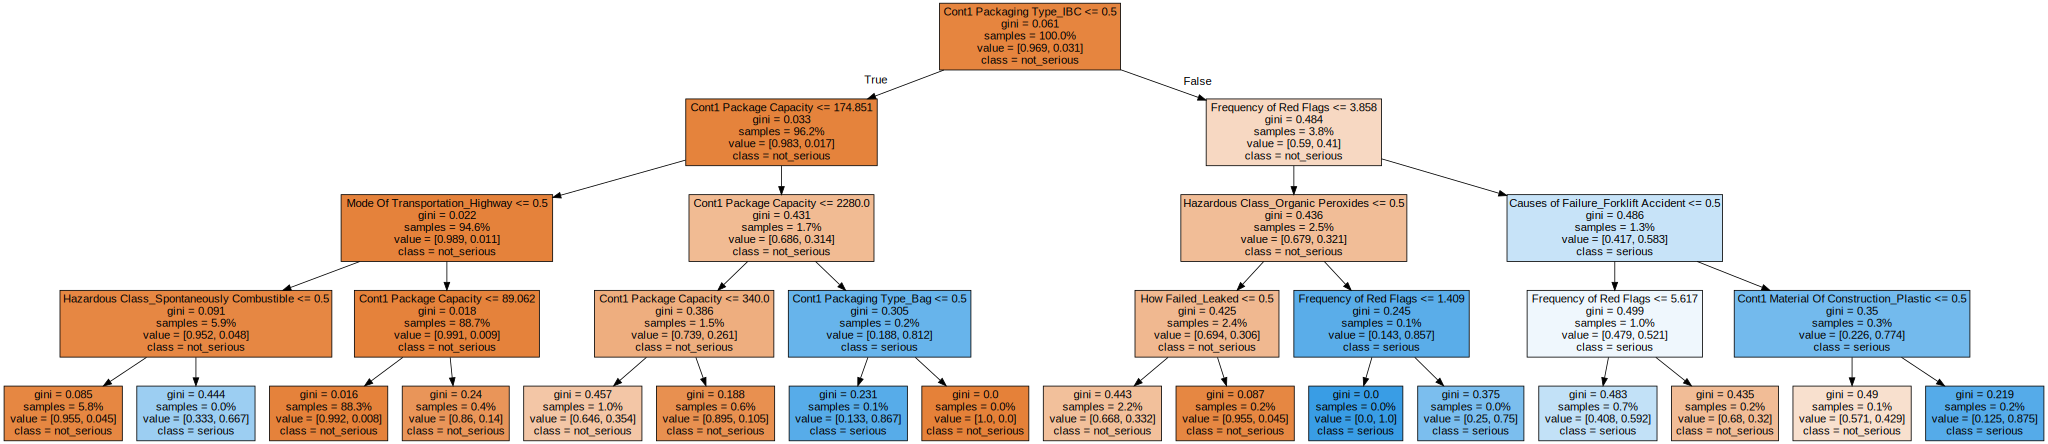

In [71]:
import pydotplus
import collections

# prepare data for visualization
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=clf.feature_names_in_,  
                                class_names=clf.classes_, filled=True, rotate=False, proportion=True)
# Draw graph
graph = graphviz.Source(dot_data, format="png") 

graph

Notable Factors Leading to Serious Incidents:



1.   Spontaneously Combustible materials being transported by highway.
2.   Large plastic IBC size containers involving forklift accidents.
3.   Large shipments of Organic Peroxides in IBC containers.
4.   Even if forklifts are not directly involved there is an increased risk of a serious incident if there are excess red flags greater than about 4 involving large shipments.
5.   Risk of leaks becoming greater in containers larger than 2,280 gallons.



In [72]:
graph = pydotplus.graph_from_dot_data(dot_data)
# save graph as .png file
graph.write_png('tree.png')

True

Next will try a different strategy for determining classes.  Label any row that has any damages relating to incidents as a *Significant Release* and any row associated with no damages as a *Not Significant Release*.

In [73]:
new_test=test_ship.copy()
new_test['Significant']=np.where((test_ship['Total Damages'] > 0 ), True, False)
new_test['Significant']=new_test['Significant'].apply(lambda x: 'Significant Release' if x==True else 'Not Significant Release')
new_test['Significant'].value_counts()


Not Significant Release    42701
Significant Release         6099
Name: Significant, dtype: int64

In [74]:
X_train=new_test.iloc[:,:31]
y_train=new_test['Significant']
clf=tree.DecisionTreeClassifier(max_depth=4)
clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=4)

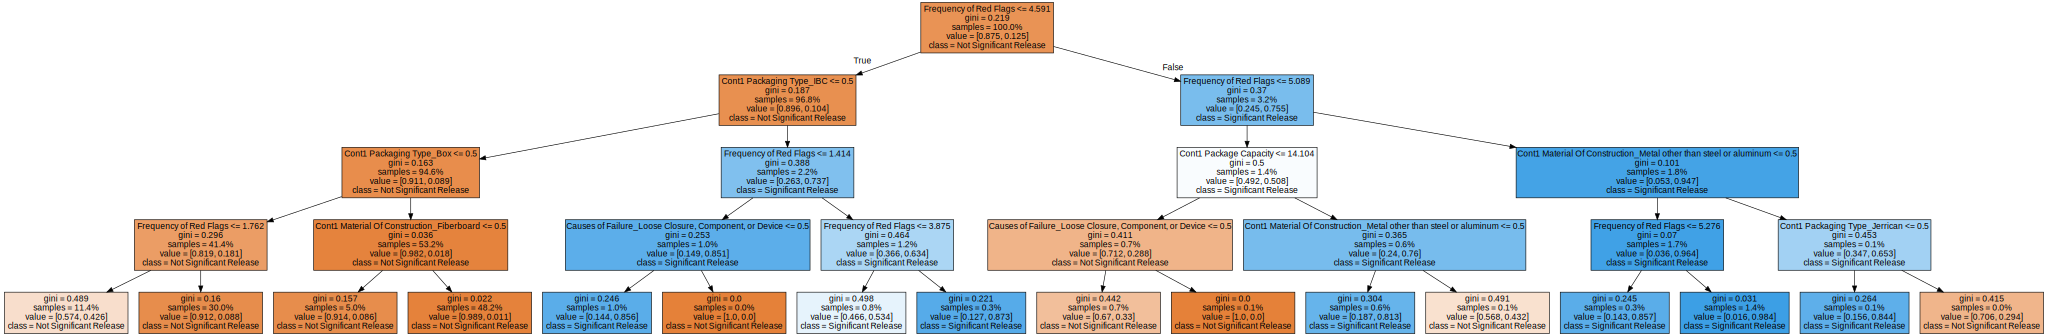

In [75]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=clf.feature_names_in_,  
                                class_names=clf.classes_, filled=True, rotate=False, proportion=True)
# Draw graph
graph = graphviz.Source(dot_data, format="png") 

graph

In [76]:
graph = pydotplus.graph_from_dot_data(dot_data)
# save graph as .png file
graph.write_png('tree-2.png')

True

Notable Factors Leading to Significant Releases:

1.   Despite little overall redflags if closure on IBC container becomes loose risk of a significant release becomes high.
2.   Increased red flags associated with IBC containers signify increased risk likely due to general packaging failures/human error.
3.   When *Frequency of Red Flags* are greater than 5 shipments involving metal containers tend to have an increase in risk of significant releases. However shipments in jerricans tend to fair a bit better.  Suspect that corrosion plays a large contribution in these failures.
4.   Metal containers made of steel or aluminum tend to have a higher risk than metal containers made of other metals such as stainless steel.




<a id='Conclusion'></a>
## Conclusion

By far the strongest indicator of if an incident involving the shipment of hazardous materials becomes serious is the size of the shipment.  Repackaging large shipments into smaller containers would decrease risk of serious incidents however doing so is likely not practical.  Repackaging 200 gallon IBC into 200 individual 1 gallon packages is unlikely to be economically viable.  

To minimize risk of serious incidents involving shipments of hazardous material lookout for the following: 

* Close inspection of closures on chemical containers.
* Inspection of the body of the shipping container.
* Any compatability issues of hazardous material and shipment container material.
* Organic Peroxides, compressed gas, flammable and corrosive materials pose a significant hazard.
* Forklift related incidents can often become less likely to become serious if package is properly prepared for shipment.  However large plastic IBC containers are highly susceptible.

